# A Pairs Trading strategy 

**Author:** Simão Moraes Sarmento <br /> 
**Contact:** simaosarmento@hotmail.com

## Dependencies

This notebook requires code from:

Python files:
- `class_SeriesAnalyser.py` - contains a set of functions to deal with time series analysis.
- `class_Trader.py` - contains a set of functions concerning trading strategies.
- `class_DataProcessor.py` - contains a set of functions concerning the data pre processing.

Pickle files:
- pickle file containing pairs to be traded (obtained from running `PairsTrading_CommodityETFs-Clustering.ipynb`)

As a good practise, the notebook solely intends to exemplify the application of different trading strategies for different dataset. Please look into the files menitoned above for more detailed info on how the functions are built.

### Import Libraries

In [2]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

# just set the seed for the random number generator
np.random.seed(107)

In [3]:
ticker_path = "data/etfs/pickle/ticker_segment_dict.pickle"
with open(ticker_path, 'rb') as handle:
    ticker_segment_dict = pickle.load(handle)

### Import Classes

In [5]:
%load_ext autoreload
%aimport class_SeriesAnalyser, class_Trader, class_DataProcessor
%autoreload 1

In [6]:
series_analyser = class_SeriesAnalyser.SeriesAnalyser()
trader = class_Trader.Trader()
data_processor = class_DataProcessor.DataProcessor()

# Retrieve prices data set

We start by retrieving the data from a Dataframe saved in a pickle file, as it was previously processed in the `PairsTrading_CommodityETFS_Datapreprocessing.ipynb` notebook.

In [7]:
# intraday
df_prices = pd.read_pickle('data/etfs/pickle/commodity_ETFs_from_2014_complete.pickle')

In [8]:
# split data in training and test
df_prices_train, df_prices_test = data_processor.split_data(df_prices,
                                                            ('01-01-2014',
                                                             '31-12-2016'),
                                                            ('01-01-2017',
                                                             '31-12-2017'),
                                                            remove_nan=True)

Total of 116 tickers
Total of 116 tickers after removing tickers with Nan values


In [9]:
len(df_prices_train)+len(df_prices_test)

78258

# Load Pairs

In [10]:
with open('data/etfs/pickle/2014-2018/pairs_category_intraday.pickle', 'rb') as handle:
    pairs = pickle.load(handle)

In [12]:
len(pairs)

51

# Apply trading strategies

**Applying the fixed beta strategy in validation period**

In [13]:
train_val_split = '2016-01-01'

# intraday
n_years_val = round(len(df_prices_train[train_val_split:])/(240*78))

# interday
#n_years_val = round(len(df_prices_train)/(240))

n_years_val

1

In [14]:
train_results_without_costs, train_results_with_costs, performance_threshold_train = \
        trader.apply_trading_strategy(pairs, 
                                       'fixed_beta',
                                        2,#entry_multiplier,
                                        0,#exit_multiplier,
                                        test_mode=False,
                                        train_val_split=train_val_split
                                       )

sharpe_results_threshold_train_nocosts, cum_returns_threshold_train_nocosts = train_results_without_costs
sharpe_results_threshold_train_w_costs, cum_returns_threshold_train_w_costs = train_results_with_costs

 entry delay turned on.
Pair: 51/51

Average SR:  1.7583849176779973
Annual ROI:  27.353628755078073
92.15686274509804 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  5.933038995347315
Autocorrelation:  0.039432529669300574
Daily Sharpe Ratio 0.3303484539093652
Total number of trades:  145
Positive trades:  127
Negative trades:  18
Max DD period: 3.0 days
Maximum drawdown of portfolio: -2.46%


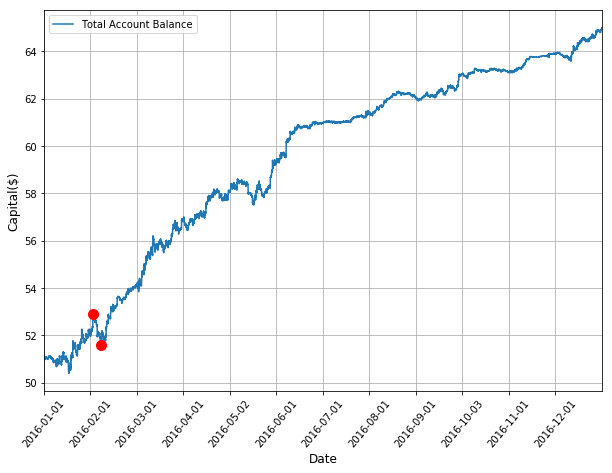

In [15]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_train_w_costs,
                                                  cum_returns_threshold_train_w_costs,
                                                  performance_threshold_train,
                                                  pairs, ticker_segment_dict,
                                                  n_years_val)

In [32]:
print('Corrected Annualized SR: {:.2f}'.format(0.3303484539093652*(252**0.5)))

Corrected Annualized SR: 5.24


Sharpe Ratio Distribution: 


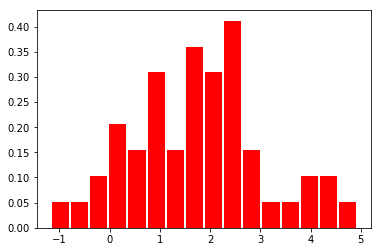

In [16]:
print('Sharpe Ratio Distribution: ')
n, bins, patches = plt.hist(sharpe_results_threshold_train_w_costs, bins = 16, normed=True, orientation='vertical',
                            color='red', rwidth=0.9, align='mid')

In [17]:
#cum_returns_threshold_train_w_costs

In [18]:
betas = list()
for i in range(len(pairs)):
    betas.append(pairs[i][2]['coint_coef'])
np.asarray(betas)

array([ 1.63886871,  0.80420701,  1.42040979,  0.52994945,  0.54473982,
        0.70408286,  0.4748504 ,  2.86102543,  0.76690102,  0.4026628 ,
        2.99238613,  0.48615418,  0.54129414,  2.28254709,  0.52498535,
        0.54170911,  2.05768111,  1.21077288,  0.24849713,  0.67796457,
        0.48938092,  1.29708082,  0.99117013,  3.2681989 ,  0.39953017,
        0.36711198,  0.44078   ,  0.9246868 ,  1.10015149,  0.35246739,
        0.36550481,  0.83662887,  0.76490773,  2.46892451,  0.44675325,
        0.03449643,  0.89761846,  0.31985708,  0.69568602,  0.28813701,
        1.41975687,  0.92548624,  0.64018377,  0.66050782,  0.35249098,
        0.36256579,  0.35973865, 25.67042149,  1.47585815,  1.60930243,
        0.29230698])

# Out of Sample Analysis

In this section, we analyze the performance of the strategy in the validation dataset. 

We proceed with some data exploration analysis. For this purpose we will do the following:

- Analyze which percentage of the identified pairs are still cointegrated in the validation period.
- Analyze which percentage of pairs have positive returns, and how many of those are still cointegrated.
- Analyze how many new pais were not identified to be cointegrated up to the validation period.
- Run strategy for identified pairs in training period.

This analysis will help us getting some insight into how the cointegrated pairs vary from time to time, and therefore how we should allocate our resources to predict when pairs are not cointegrated anymore.

## Applying the Strategy out-of Sample

We might want to apply the strategy in all pairs identified. Or, instead, we might prefer to apply the strategy only on those pairs that turned out to be profitable. Let's compare how both approaches work:

In [19]:
# intraday
n_years_test = round(len(df_prices_test)/(240*78))

# interday
#n_years_test = round(len(df_prices_test)/(240))

n_years_test

1

### Approach 1: Unrestricted

**Basic Threshold Strategy**

In [20]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 51/51

Average SR:  0.5197491155270365
Annual ROI:  7.862648797636029
64.70588235294117 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.0394098289040694
Autocorrelation:  -0.09907142108718914
Daily Sharpe Ratio 0.12411870028578668
Total number of trades:  64
Positive trades:  49
Negative trades:  15
Max DD period: 14.0 days
Maximum drawdown of portfolio: -2.47%


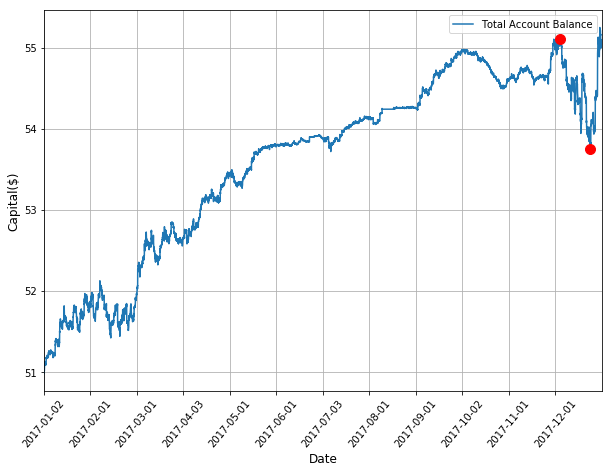

In [21]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  pairs, ticker_segment_dict,
                                                  n_years_test)

In [33]:
print('Corrected Annualized SR: {:.2f}'.format(0.12411870028578668*17.47))

Corrected Annualized SR: 2.17


### Approach 2: Keeping only pairs that had positive returns in the training period

In [22]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
profitable_pairs_indices = np.argwhere(cum_returns_threshold_train_w_costs > 0)
profitable_pairs = [pairs[i] for i in profitable_pairs_indices.flatten()]

In [23]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(profitable_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 47/47

In [24]:
_, _, _, _ = trader.calculate_metrics(sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs,
                                      n_years_test)

Average SR:  0.542074843651186
Annual ROI:  8.422722186709342
63.829787234042556 % of the pairs had positive returns


Average SR:  0.542074843651186
Annual ROI:  8.422722186709342
63.829787234042556 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  2.0145353128260672
Autocorrelation:  -0.10105889630464142
Daily Sharpe Ratio 0.12238852236042314
Total number of trades:  54
Positive trades:  43
Negative trades:  11
Max DD period: 16.0 days
Maximum drawdown of portfolio: -2.67%


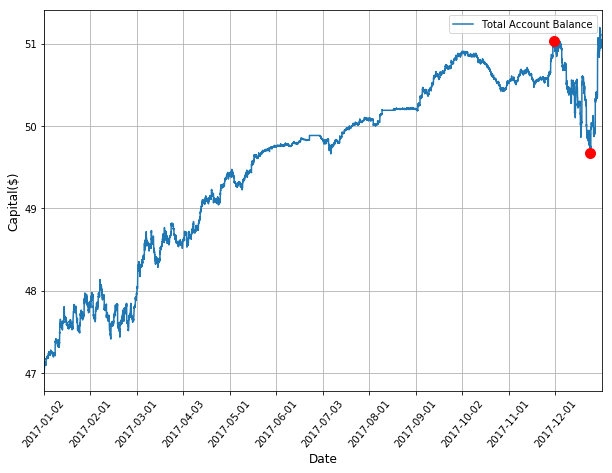

In [25]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  profitable_pairs, ticker_segment_dict,
                                                  n_years_test)

In [34]:
print('Corrected Annualized SR: {:.2f}'.format(0.12238852236042314*17.47))

Corrected Annualized SR: 2.14


### Approach 3: Keeping only top 10 pairs

In [26]:
sharpe_results_threshold_train_w_costs = np.asarray(sharpe_results_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(sharpe_results_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [27]:
# sorting by returns seems to give better results

In [28]:
cum_returns_threshold_train_w_costs = np.asarray(cum_returns_threshold_train_w_costs)
sorted_pairs_indices = np.argsort(cum_returns_threshold_train_w_costs)[::-1][:10]
top_10_pairs = [pairs[i] for i in sorted_pairs_indices.flatten()]

In [29]:
results_without_costs, results_with_costs, performance_threshold_test = \
                            trader.apply_trading_strategy(top_10_pairs, 
                                                           'fixed_beta',
                                                            2,#entry_multiplier,
                                                            0,#exit_multiplier,
                                                            test_mode=True,
                                                            train_val_split=train_val_split
                                                           )
sharpe_results_threshold_test_nocosts, cum_returns_threshold_test_nocosts = results_without_costs
sharpe_results_threshold_test_w_costs, cum_returns_threshold_test_w_costs = results_with_costs

 entry delay turned on.
Pair: 10/10

Average SR:  0.6487707020246009
Annual ROI:  8.31342711575438
90.0 % of the pairs had positive returns
Sharpe Ratio assumming IID returns:  0.8027438431512045
Autocorrelation:  -0.05396992751845838
Daily Sharpe Ratio 0.05071277412387045
Total number of trades:  13
Positive trades:  12
Negative trades:  1
Max DD period: 16.0 days
Maximum drawdown of portfolio: -8.91%


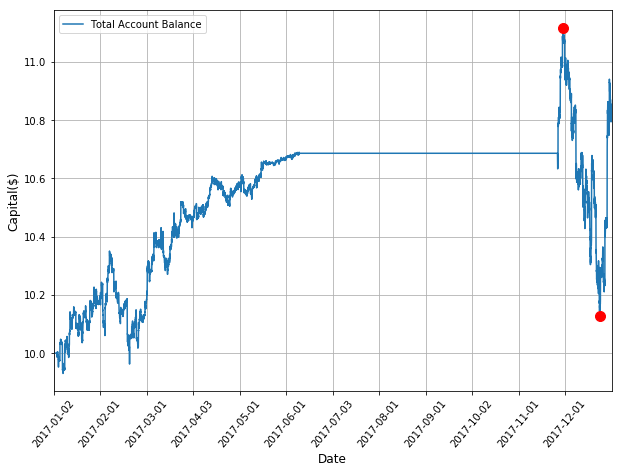

In [30]:
results, pairs_summary = trader.summarize_results(sharpe_results_threshold_test_w_costs,
                                                  cum_returns_threshold_test_w_costs,
                                                  performance_threshold_test,
                                                  top_10_pairs, ticker_segment_dict,
                                                  n_years_test)

In [35]:
print('Corrected Annualized SR: {:.2f}'.format(0.05071277412387045*17.47))

Corrected Annualized SR: 0.89


In [31]:
pairs_summary

,Leg1,Leg1_Segmt,Leg2,Leg2_Segmt,t_statistic,p_value,zero_cross,half_life,hurst_exponent,positive_trades,negative_trades,sharpe_result,positive_trades_per_pair_pct
0,ENFR,Equity: U.S. MLPs,YMLI,Equity: U.S. MLPs,-4.045626,0.001190,609,124,0.218409,3,0,2.058766,100.0
1,PXJ,Equity: U.S. Oil & Gas Equipment & Services,USO,Commodities: Energy Crude Oil,-3.864739,0.002310,411,731,0.433987,1,0,1.475021,100.0
2,DBO,Commodities: Energy Crude Oil,PXJ,Equity: U.S. Oil & Gas Equipment & Services,-3.667985,0.004587,399,787,0.434291,1,0,1.438126,100.0
3,AMLP,Equity: U.S. MLPs,ENFR,Equity: U.S. MLPs,-3.631002,0.005195,801,219,0.284800,1,0,0.846866,100.0
4,PSCE,Equity: U.S. Energy,UNL,Commodities: Energy Natural Gas,-3.503207,0.007905,236,1149,0.455811,2,0,0.680468,100.0
5,XES,Equity: U.S. Oil & Gas Equipment & Services,UNL,Commodities: Energy Natural Gas,-3.463195,0.008984,393,1255,0.462842,1,0,0.636636,100.0
6,DTO,Inverse Commodities: Energy Crude Oil,KOLD,Inverse Commodities: Energy Natural Gas,-4.063344,0.001113,183,1233,0.478179,1,0,0.021187,100.0
7,SCO,Inverse Commodities: Energy Crude Oil,KOLD,Inverse Commodities: Energy Natural Gas,-3.820588,0.002704,347,1527,0.488263,1,0,0.004656,100.0
8,UGA,Commodities: Energy Gasoline,UNG,Commodities: Energy Natural Gas,-3.826968,0.002643,382,1259,0.489978,1,0,-0.067257,100.0
9,DBE,Commodities: Energy,UNL,Commodities: Energy Natural Gas,-3.780758,0.003110,335,925,0.445612,0,1,-0.606763,0.0
